In [ ]:
# Scene Recognition with Deep Learning

## Outline
In this project, we will use *convolutional neural nets* to classify images into different scenes.

Basic learning objectives of this project:
1. Construct the fundamental pipeline for performing deep learning using PyTorch;
2. Understand the concepts behind different layers, optimizers.
3. Experiment with different models and observe the performance.

The starter code is mostly initialized to 'placeholder' just so that the starter
code does not crash when run unmodified and you can get a preview of how
results are presented.

## Compute Requirements

This project is doable without a GPU, but a GPU makes the process much more faster and frustration free.

You can try out Google Colab to run this notebook. These are the steps we follow:
1. Upload this notebook to google colab
2. Zip all the components in the project directory and upload it to the colab runtime
3. Unzip the uploaded zip using ```!unzip -qq <uploaded_file>.zip -d ./```

Remember to download all the files saved and changes to code you made on the colab.

Note that we will not be actively supporting issues with Google colab. Please take help from fellow students and use the internet to solve the issues.

## Dataset
You would have already stored the dataset in the ```data``` folder. It is the same data you have used in PS4. It has two subfolders: ```train``` and ```test```. Go through any of the folder and find there you will find the folders with scene names like *bedroom*, *forest*, *office*. These are the 15 scenes that we want our model to predict given an RGB image. You can look into folder for each scene to find multiple images. All this data is labelled data provided to you for training and testing your model.

**Let's start coding now!**

## Setup

In [ ]:
# uncomment for running on colab
# !unzip -qq proj5_colab.zip -d ./

In [1]:
# flag to modify paths to run better on Colab; change it to true if you want to run on colab
use_colab_paths = False 

## Setup

In [2]:
import os
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder

from proj5_code.runner import Trainer
from proj5_code.optimizer import compute_quadratic_loss, get_optimizer, gradient_descent_step
from proj5_code.simple_net import SimpleNet
from proj5_code.simple_net_dropout import SimpleNetDropout
from proj5_code.my_alexnet import MyAlexNet
from proj5_code.data_transforms import get_fundamental_transforms, get_data_augmentation_transforms
from proj5_code.stats_helper import compute_mean_and_std
from proj5_code.vis import visualize

%load_ext autoreload
%autoreload 2

In [3]:
from proj5_code.proj5_unit_tests.test_base import verify
from proj5_code.proj5_unit_tests.test_stats_helper import test_mean_and_variance
from proj5_code.proj5_unit_tests.test_data_transforms import test_fundamental_transforms
from proj5_code.proj5_unit_tests.test_dl_utils import test_predict_labels, test_compute_loss
from proj5_code.proj5_unit_tests.test_simple_net import test_simple_net
from proj5_code.proj5_unit_tests.test_simple_net_dropout import test_simple_net_dropout
from proj5_code.proj5_unit_tests.test_my_alexnet import test_my_alexnet
from proj5_code.proj5_unit_tests.test_checkpoints import test_simple_net_checkpoint
from proj5_code.proj5_unit_tests.test_optimizer import test_compute_quadratic_loss, test_gradient_descent_step

In [4]:
is_cuda = True
# torch.cuda.is_available() checks if there is a GPU on the system and it has CUDA drivers installed
# CUDA helps accelerate operations in Pytorch
is_cuda = is_cuda and torch.cuda.is_available() 

In [5]:
data_base_path = '../data/' if not use_colab_paths else 'data/'
model_base_path = '../model_checkpoints/' if not use_colab_paths else 'model_checkpoints/'

In [6]:
print(os.listdir(data_base_path))
print(os.listdir(model_base_path))

# TODO: check that these outputs are as per expectation. It will save a lot of time in debugging issues.

['test', 'train']
['.DS_Store', 'simple_net', 'simple_net_dropout', 'alexnet']


To train a network in PyTorch, we need 4 components:
1. **Dataset** - an object which can load the data and labels given an index.
2. **Model** - an object that contains the network architecture definition.
3. **Loss function** - a function that measures how far the network output is from the ground truth label.
4. **Optimizer** - an object that optimizes the network parameters to reduce the loss value.

## 1 Dataset
The dataset is in the ```data``` folder. It has two subfolders: ```train``` and ```test```. Go through any of the folder and find there you will find the folders with scene names like *bedroom*, *forest*, *office*. These are the 15 scenes that we want our model to predict given an RGB image. You can look into folder for each scene to find multiple images. All this data is labelled data provided to you for training and testing your model.

**Let's start coding now!**

One crucial aspect of deep learning is to perform data preprocessing. In DL, we usually *normalize* the dataset and perform some *transformations* on them. The transformations can either help the inputs be compatible with the model (say our model only works on 500x500 images and we need all input to be cropped/scaled to this size) or help in data-augmentation to improve performance (more on this later).


### 1.1 Compute mean and standard deviation of the dataset
In this project we are going to "zero-center" and "normalize" the dataset so that each entry has zero mean and the overall standard deviation is 1. To do this, we will compute the mean and variance of the actual dataset first. To perform actual normalization, we will use a transform from Pytorch. 

**TODO 1**:  fill in the `compute_mean_and_std()` in `stats_helper.py` to compute the **mean** and **standard deviation** of both training and test set combined.

Debug tip: If you face an error from StandardScaler about attribute not found, please check that the paths are correct and your code actually finds some images.

In [7]:
print("Testing your mean and std computation: ", verify(test_mean_and_variance))
dataset_mean, dataset_std = compute_mean_and_std(data_base_path)

Testing your mean and std computation:  "Correct"


In [8]:
print('Dataset mean = {}, standard deviation = {}'.format(dataset_mean, dataset_std))

Dataset mean = [0.45547486], standard deviation = [0.25316328]


### 1.2 Data Loader

We'll have stored our input images in a specific format: each class name is a folder, with images belonging to that class inside the folder. This specific choice of storage scheme enables us to directly use the [`ImageFolder` ](https://pytorch.org/vision/stable/datasets.html#imagefolder) dataset from Pytorch.

We'll use the `ImageFolder` to make two loaders, for train and test split respectively.

In [9]:
train_loader = ImageFolder(root=os.path.join(data_base_path, 'train'))
test_loader = ImageFolder(root=os.path.join(data_base_path, 'test'))

In [10]:
print(f"Number of entries in training set: {len(train_loader)}")
print(f"Number of entries in test set: {len(test_loader)}")

Number of entries in training set: 2985
Number of entries in test set: 1500


Visualizing some examples from the training set

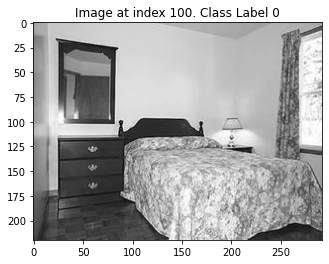

In [11]:
idx = 100

image, class_label = train_loader.__getitem__(idx)
plt.figure()
plt.imshow(image)
plt.title(f'Image at index {idx}. Class Label {class_label}')
plt.show()

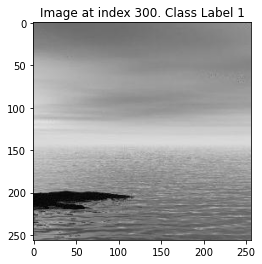

In [12]:
idx = 300

image, class_label = train_loader.__getitem__(idx)
plt.figure()
plt.imshow(image)
plt.title(f'Image at index {idx}. Class Label {class_label}')
plt.show()

### 1.3 Data transforms
In this section, we will construct some fundamental transforms to process RGB images into torch tensors, which we can provide as input to our model.

1. Resize the input image to the desired shape
2. Convert to a single channel grayscale image (ImageFolder will read the image as a color image with 3 channels, even though the colors are all gray).
3. Convert it to a tensor
4. Normalize them based on the mean and standard deviation already computed in 1.1.

All these operations can be done using [torchvision's transforms](https://pytorch.org/vision/stable/transforms.html). You'll need to write one line for each operation.

**TODO 2:** For this part, complete the function `get_fundamental_transforms()` in `data_transforms.py` 

In [13]:
print("Testing your fundamental data transforms: ", verify(test_fundamental_transforms))

Testing your fundamental data transforms:  "Correct"


## 2 Model Architecture and Forward Pass

In [14]:
inp_size = (64,64) # input size to use for this section

### 2.1 SimpleNet Model

The data is ready! Now we are preparing to move to the actual core of deep learning: the architecture. To get you started in this part, simply define a **2-layer** model in the `simple_net.py`. Here by "2 layers" we mean **2 convolutional layers**, so you need to figure out the supporting utilities like ReLU, Max Pooling, and Fully Connected layers, and configure them with proper parameters (such as kernel size, padding, etc) such that the output from a layer is compatible as input to the next layer.

You may refer the image *simplenet.jpg* in the base folder for a sample network architecture (it's the architecture TAs used in their implementation and is sufficient to get you pass Part 1). In that image, the layers in use are written at the bottom, and the blocks show the shape of features after each layer.

Note that the input image will be shaped as (N, C, H, W) where N are the number of images in a batch, C is the number of color channels in the image, H is the height, and W is the width.

**TODO 3**: Do the following in ```simple_net.py```:
- Initialize ```self.conv_layers```
- Initialize ```self.fc_layers```
- Write the forward function

Leave the ```self.loss_criterion = None``` for now.

### 2.2 Output prediction

In [16]:
print("Testing your SimpleNet architecture: ", verify(test_simple_net))

Testing your SimpleNet architecture:  "Correct"


Let's see what out model's forward function produces for a sample input, and how it relates to classification. Pytorch's convolution and FC layers are initialized with random weights. So we should not expect any useful output without any training.

We will use a data-point from a new `ImageFolder` object with the transformations we have defined.

In [17]:
simple_model = SimpleNet()

train_loader = ImageFolder(root=os.path.join(data_base_path, 'train'), 
                           transform=get_fundamental_transforms(inp_size, dataset_mean, dataset_std))

In [18]:
# get the 0th sample
sample_image, sample_label = next(iter(train_loader))

In [19]:
print('Input image shape = ', sample_image.shape)

Input image shape =  torch.Size([1, 64, 64])


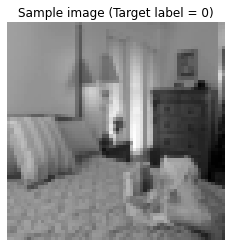

In [20]:
#show the image
fig, axs = plt.subplots()
axs.imshow(sample_image.squeeze().numpy(), cmap='gray')
axs.axis('off')
axs.set_title('Sample image (Target label = {})'.format(sample_label))
plt.show()

In [21]:
# run the image through the model
sample_model_output = simple_model(sample_image.unsqueeze(0)).detach()

In [22]:
print(sample_model_output)

tensor([[-0.0545, -0.0393, -0.1885, -0.0562,  0.0649, -0.1229, -0.0594, -0.0138,
         -0.0975,  0.0397, -0.0889, -0.0068, -0.0673,  0.0342,  0.0790]])


We have a 15-dimensional tensor as output, but how does it relate to classification?

We first convert the this tensor into a probability distribution over 15 classes by applying the [Softmax](https://en.wikipedia.org/wiki/Softmax_function) operation.

In [23]:
sample_probability_values = torch.nn.functional.softmax(sample_model_output, dim=1)

In [24]:
print(sample_probability_values)

tensor([[0.0654, 0.0664, 0.0572, 0.0653, 0.0737, 0.0611, 0.0651, 0.0682, 0.0627,
         0.0719, 0.0632, 0.0686, 0.0646, 0.0715, 0.0748]])


In [25]:
print("Sum of probability values: ", torch.sum(sample_probability_values))

Sum of probability values:  tensor(1.0000)


The prediction of the model will be the index where the probability distribution is the maximum. Convince yourself that the argmax-operation on *sample_model_values* is the same as the argmax-operation on *sample_probability_values*. Hence for prediction, we can take the argmax on the model output directly without applying a softmax. Also, you can check that the sum of softmax values is 1 and hence they are valid probability values.

**TODO 4:** Complete the ```predict_labels()``` function in ```dl_utils.py```.

## 3 Loss function

We have written a model which takes in a tensor for an image and produces a 15 dimensional output for it. We saw in the previous section on how the output relates to the prediction and probability distribution. But how do we quantify the performance of the model, and how do we use that quantification to form an objective function which we can minimize.

Ideally, we would want the probability function to have value 1 for the target *sample_label* and value 0 for the remaining class indices. To penalize the deviation between the desired probability distribution and the model-predicted distrtibution, we use the KL-divergence loss or the cross-entropy loss. Please refer to [this stackexchange post](https://datascience.stackexchange.com/questions/20296/cross-entropy-loss-explanation) for a good explanation and derivation.

**TODO 5:** Assign a loss function to ```self.loss_criterion``` in ```simple_net.py```. Note that we have not done a softmax operation in the model's forward function and choose the [appropriate loss function](https://pytorch.org/docs/stable/nn.html#loss-functions). In this TODO, you just have to assign the correct loss function in the model. 

**TODO 6:** Complete the ```compute_loss()``` function in ```dl_utils.py``` to use the model's loss criterion and compute the loss.

In [26]:
simple_model = SimpleNet()

In [27]:
print(simple_model)

SimpleNet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=720, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=15, bias=True)
  )
  (loss_criterion): CrossEntropyLoss()
)


In [28]:
print("Testing your model prediction: ", verify(test_predict_labels))
print("Testing your loss values: ", verify(test_compute_loss))

Testing your model prediction:  "Correct"
Testing your loss values:  "Correct"


## 4 Optimizer

### 4.1 Manual gradient descent using Pytorch's autograd

Till now, we have defined the model, and designed a loss function which is a proxy for *good* classification. We now to optimize the weights of the network so that the loss function is minimized.

Pytorch is a very useful library for deep learning because a lot of tensor operations and functions support the flow of gradients. This feature is called [autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html). This functionality lets use use gradient based optimization techniques like gradient descent without writing a lot of code.

Let us first understand how we can access the gradients.

### Define an objective function (equivalent to the loss we defined in Section 3)
Suppose we have a simple objective function that looks like:
$$ L(w) =  w^2 - 10w + 25 $$

This is a convex problem, and we know that the loss $L$ is minimized for $w=5$, and we can obtain this in closed form.

But let us use gradient descent to obtain the solution in this case.

**TODO 7:** Complete `compute_quadratic_loss` in `optimizer.py`

In [30]:
print("Testing your quadratic loss function: ", verify(test_compute_quadratic_loss))

Testing your quadratic loss function:  "Correct"


Let's compute the loss at w = 0.

In [33]:
w = torch.tensor([0.0], requires_grad=True) # we mark this tensor to require gradient so that the computation graph
# can account for it

loss = compute_quadratic_loss(w)

print('w={:.4f}\tLoss={:.4f}'.format(w.detach().numpy().item(), loss.detach().numpy().item()))

w=0.0000	Loss=25.0000


Now we can do a backward pass of the gradients to get the gradient of loss w.r.t w. Now we need to calculate the gradients with regard to the weights and biases using backprop. It will be very painful if we do it manually, but thankfully, in PyTorch we can have everything covered with autograd, which only needs a simple call of **.backward()** on our loss.

In [34]:
# perform a backward pass on loss (we need to retain graph here otherwise Pytorch will throw it away)
loss.backward(retain_graph=True)

print(w.grad.data)

# manually zero out the gradient
w.grad.zero_()
pass


tensor([-10.])


Does this gradient match with the one you compute manually?

With the gradients, we can update the weights and biases using gradient descent:
$$w_{k+1}=w_{k} - \alpha\frac{\partial L}{\partial w_k}$$
where $w$ is the parameter we are updating, $\alpha$ is the learning rate, and $\frac{\partial L}{\partial w_k}$ is the gradient at step $k$. You can learn more about gradient descent [here](https://en.wikipedia.org/wiki/Gradient_descent) and [here](https://developers.google.com/machine-learning/crash-course/reducing-loss/gradient-descent)

**TODO 8:** Implement a single step of gradient descent in function `gradient_descent_step` in `optimizer.py`

In [36]:
print("Testing gradient descent step: ", verify(test_gradient_descent_step))

tensor([2.], requires_grad=True)
Testing gradient descent step:  "Correct"


Let's take one step of the gradient descent and check if the the loss value decreased

In [37]:
# set learning rate
lr = .03

loss = compute_quadratic_loss(w)
gradient_descent_step(w, loss, lr) 

In [38]:
loss = compute_quadratic_loss(w)
print('w={:.4f}\tLoss={:.4f}'.format(w.detach().numpy().item(), loss.detach().numpy().item()))

w=0.3000	Loss=22.0900


Looks like it's been optimized!

Now let's run a few more updates and see where we can get!

In [39]:
import time


start = time.time()
for i in range(200):
    loss = compute_quadratic_loss(w)
    if not (i+1)%10:
        print('Iteration {}: w={:.4f}\tLoss={:.4f}'.format(
            i+1, w.detach().numpy().item(), loss.detach().numpy().item()))
        
    gradient_descent_step(w, loss, lr) 
        
print('\noptimization takes %0.3f seconds'%(time.time()-start))

Iteration 10: w=2.3069	Loss=7.2527
Iteration 20: w=3.5495	Loss=2.1040
Iteration 30: w=4.2187	Loss=0.6104
Iteration 40: w=4.5792	Loss=0.1771
Iteration 50: w=4.7733	Loss=0.0514
Iteration 60: w=4.8779	Loss=0.0149
Iteration 70: w=4.9342	Loss=0.0043
Iteration 80: w=4.9646	Loss=0.0013
Iteration 90: w=4.9809	Loss=0.0004
Iteration 100: w=4.9897	Loss=0.0001
Iteration 110: w=4.9945	Loss=0.0000
Iteration 120: w=4.9970	Loss=0.0000
Iteration 130: w=4.9984	Loss=0.0000
Iteration 140: w=4.9991	Loss=0.0000
Iteration 150: w=4.9995	Loss=0.0000
Iteration 160: w=4.9997	Loss=0.0000
Iteration 170: w=4.9999	Loss=0.0000
Iteration 180: w=4.9999	Loss=0.0000
Iteration 190: w=5.0000	Loss=-0.0000
Iteration 200: w=5.0000	Loss=0.0000

optimization takes 0.050 seconds


Seems that it's doing a great job training our model! The loss now has decreased significantly to a pretty small value.

### 4.2 Optimization using Pytorch's gradient descent optimizer

Now let's see how we can simplify this using the `torch.optim` package from PyTorch. You can see that using optimizer from `torch.optim` package can achieve the same results with a lot less code from our side. Also, there are many features available over the vanilla gradient descent. Let's use the Stochastic Gradient Descent (SGD) optimizer available in Pytorch.

In [40]:
from torch.optim import SGD

# define parameters we want to optimize
w = torch.tensor([0.0], requires_grad=True)

optimizer = SGD([w], lr=lr)

start = time.time()
for i in range(200):
    loss = compute_quadratic_loss(w)   
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if not (i+1)%10:
        print('Iteration {}: w={:.4f}\tLoss={:.4f}'.format(
            i+1, w.detach().numpy().item(), loss.detach().numpy().item()))
        
print('\noptimization takes %0.3f seconds'%(time.time()-start))

Iteration 10: w=2.3069	Loss=8.2081
Iteration 20: w=3.5495	Loss=2.3812
Iteration 30: w=4.2187	Loss=0.6908
Iteration 40: w=4.5792	Loss=0.2004
Iteration 50: w=4.7733	Loss=0.0581
Iteration 60: w=4.8779	Loss=0.0169
Iteration 70: w=4.9342	Loss=0.0049
Iteration 80: w=4.9646	Loss=0.0014
Iteration 90: w=4.9809	Loss=0.0004
Iteration 100: w=4.9897	Loss=0.0001
Iteration 110: w=4.9945	Loss=0.0000
Iteration 120: w=4.9970	Loss=0.0000
Iteration 130: w=4.9984	Loss=0.0000
Iteration 140: w=4.9991	Loss=0.0000
Iteration 150: w=4.9995	Loss=0.0000
Iteration 160: w=4.9997	Loss=0.0000
Iteration 170: w=4.9999	Loss=0.0000
Iteration 180: w=4.9999	Loss=0.0000
Iteration 190: w=5.0000	Loss=0.0000
Iteration 200: w=5.0000	Loss=0.0000

optimization takes 0.044 seconds


### 4.3 Setting up the optimizer for SimpleNet

**TODO 9:** **initialize the following cell with proper values for learning rate and weight decay** 

**Note:** There is nothing to do in this TODO for the first pass. You'll train the model with these values and it will be bad. Then you can come back here and tune the parameters.

In [65]:
# TODO: add a decent initial setting and tune from there
optimizer_config = {
  "optimizer_type": "adam",
  "lr": 1e-3, 
  "weight_decay": 1e-5
}

We will now set up a utility function to define an optimizer on the loss for a model.

**TODO 10:** complete the ```get_optimizer()``` function in ```optimizer.py```. The helper function accepts three basic configurations as defined below. Any other configuration is optional. *SGD* optimizer type should be supported, anything else is optional.

In [66]:
optimizer = get_optimizer(simple_model, optimizer_config)

## 5 Training SimpleNet

We have completed all the components required to train the first model for this course. Let's pass in the model architecture, optimizer, transforms for both the training and testing datasets into the trainer, and proceed to the next cell to train it. If you have implemented everything correctly, you should be seeing a decreasing loss value.

**Note** in this project, we will be using the test set as the validation set (i.e. using it to guide our decisions about models and hyperparamters while training). In actual practise, you would not interact with the test set until reporting the final results.

**Note** that your CPU should be sufficient to handle the training process for all networks in this project, and the following training cells will take less than 5 minutes; you may also want to decrease the value for `num_epochs` and quickly experiment with your parameters. The default value of **30** is good enough to get you around the threshold for Part 1, and you are free to increase it a bit and adjust other parameters in this part.

In [67]:
# re-init the model so that the weights are all random
simple_model = SimpleNet()
optimizer = get_optimizer(simple_model, optimizer_config)

trainer = Trainer(data_dir=data_base_path, 
                  model = simple_model,
                  optimizer = optimizer,
                  model_dir = os.path.join(model_base_path, 'simple_net'),
                  train_data_transforms = get_fundamental_transforms(inp_size, dataset_mean, dataset_std),
                  test_data_transforms = get_fundamental_transforms(inp_size, dataset_mean, dataset_std),
                  batch_size = 32,
                  load_from_disk = False,
                  cuda = is_cuda
                 )

In [68]:
import time
simple_net_start = time.time()
trainer.train(num_epochs=30)
simple_net_end = time.time()
print("The training time taken for simple net is {:.9f}".format(simple_net_end-simple_net_start))

Epoch:0, Training Loss:2.7120, Validation Loss:2.7134
Epoch:1, Training Loss:2.0988, Validation Loss:2.2090
Epoch:2, Training Loss:1.6368, Validation Loss:1.8400
Epoch:3, Training Loss:1.4613, Validation Loss:1.7178
Epoch:4, Training Loss:1.2720, Validation Loss:1.6445
Epoch:5, Training Loss:1.1706, Validation Loss:1.6115
Epoch:6, Training Loss:1.0630, Validation Loss:1.5376
Epoch:7, Training Loss:1.0096, Validation Loss:1.5604
Epoch:8, Training Loss:0.9758, Validation Loss:1.5806
Epoch:9, Training Loss:0.8102, Validation Loss:1.5151
Epoch:10, Training Loss:0.7474, Validation Loss:1.5211
Epoch:11, Training Loss:0.7042, Validation Loss:1.5880
Epoch:12, Training Loss:0.6551, Validation Loss:1.6436
Epoch:13, Training Loss:0.5181, Validation Loss:1.6492
Epoch:14, Training Loss:0.5651, Validation Loss:1.8652
Epoch:15, Training Loss:0.4378, Validation Loss:1.7376
Epoch:16, Training Loss:0.3910, Validation Loss:1.8093
Epoch:17, Training Loss:0.3569, Validation Loss:1.9809
Epoch:18, Training L

Now let's have your model predict on some examples and see how well it performs qualitatively. You should try the following cell multiple times to understand whats happening.

Examples from train split:


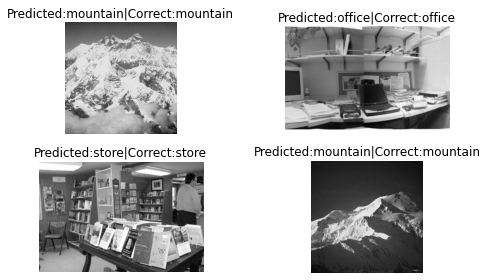

In [69]:
# visualize train split
print("Examples from train split:")
visualize(simple_model, 'train', get_fundamental_transforms(inp_size, dataset_mean, dataset_std), data_base_path)

Examples from test split:


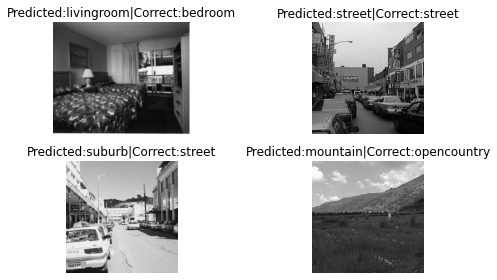

In [70]:
# visualize test split
print("Examples from test split:")
visualize(simple_model, 'test', get_fundamental_transforms(inp_size, dataset_mean, dataset_std), data_base_path)

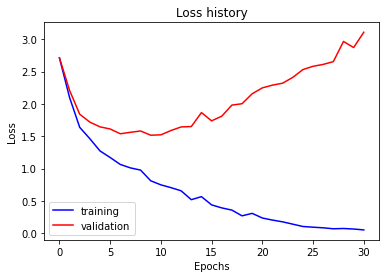

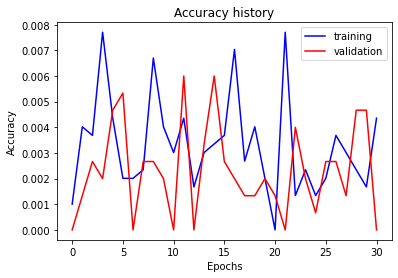

In [71]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [72]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print('Train Accuracy = {:.4f}; Validation Accuracy = {:.4f}'.format(train_accuracy, validation_accuracy))

Train Accuracy = 0.0044; Validation Accuracy = 0.0000


In [ ]:
print('Testing simple net weights saved: ', verify(test_simple_net_checkpoint))

After you have finished the training process, now plot out the loss and accuracy history. You can also check out the final accuracy for both training and validation data. Copy the accuracy plots and values onto the report, and answer the questions there. 

**TODO 11:** Obtain a **45%** validation accuracy to receive full credits for Part 1. You can go back to TODO 8 first to tune your paramters for optimization using the following tips:

**Tips**:
1. If the loss decreases very slowly, try increasing the value of the lr (learning rate).
2. Initially keep the value of weight decay (L2-regularization) very low. Even zero is fine. Use the weight decay as the last resort.
3. Try to first adjust lr in multiples of 3 initially. When you are close to reasonable performance, do a more granular adjustment. Do try to keep lr values less than 0.1.
4. If you want to increase the validation accuracy by a little bit, try increasing the weight_decay to prevent overfitting. Do not use tricks from Section 6 just yet.

If you still need to tweak the model architecture, you are free to do so. But remember complex models will require more time to train, and TAs could achieve ~50% accuracy with the described model.

## EC1 Solving overfitting
We have obtained a 45% accuracy on the validation data with a simple model; Feeling even better for the training accuracy right? More than 90% (if you have implemented everything correctly). But should you?

Our final accuracies for training and validation data differ a lot from each other, which indicates that the model we have defined **fits too well with the training data, but is unable to generalize well on data it has not trained on**: this is often regarded as **overfitting**. In this section we are going to apply 2 techniques to tackle with it: adjusting both data and model.

References:
- https://www.cs.princeton.edu/courses/archive/spring16/cos495/slides/ML_basics_lecture6_overfitting.pdf

### EC1.1 Jitter, Random Flip, and Normalization
One common technique to increase the "variability" of the data is to **augment** it. Firstly, we don't have a huge amount of data, so let's "jitter" it; secondly, when you mirror an image of a **kitchen**, you can tell that the mirrored image is still a kitchen. 

**TODO 12:** finish the `get_data_augmentation_transforms()` function in `data_transforms.py`: you should first copy your existing fundamental transform implementation into this function, and then insert other which help you do the above adjustment before the fundamental ones.


You are free to experiment with different kinds of augmentation techniques by adding new techniques or replacing existing techniques

In [46]:
inp_size = (64,64)

### EC1.2 Dropout
"Dropout" is a technique commonly used to regularize the network. It randomly turns off the connection between neurons inside the network and prevent the network from relying too much on a specific neuron. 

References: 
- https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf
- https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/

**TODO 13:** finish the `simple_net_dropout.py` with your previous SimpleNet model, plus the dropout layer. Think where you want the dropout should be places: fully connected layers, conv layers, or both? Generally the layer with more number of parameters might be more prone to overfitting.

If you are skipping this part, copy over the exact simple net arhcitecute. You will fail the following unit test but you can ignore it.

In [47]:
print("Testing your SimpleNetDropout architecture: ", verify(test_simple_net_dropout))

Testing your SimpleNetDropout architecture:  "Correct"


In [48]:
simple_model_dropout = SimpleNetDropout()
print(simple_model_dropout)

SimpleNetDropout(
  (conv_layers): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.1, inplace=False)
    (5): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
    (6): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.1, inplace=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=720, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=15, bias=True)
  )
  (loss_criterion): CrossEntropyLoss()
)


Similar to the previous part, **initialize the following cell with proper values for learning rate and weight decay**.

In [51]:
# TODO: add a decent initial setting and tune from there
optimizer_config = {
  "optimizer_type": "adam",
  "lr": 1e-4,
  "weight_decay": 1e-4
}

In [52]:
simple_model_dropout = SimpleNetDropout()
optimizer = get_optimizer(simple_model_dropout, optimizer_config)

trainer = Trainer(data_dir=data_base_path, 
                  model = simple_model_dropout,
                  optimizer = optimizer,
                  model_dir = os.path.join(model_base_path, 'simple_net_dropout'),
                  train_data_transforms = get_data_augmentation_transforms(inp_size, dataset_mean, dataset_std),
                  test_data_transforms = get_fundamental_transforms(inp_size, dataset_mean, dataset_std),
                  batch_size = 32,
                  load_from_disk = False,
                  cuda = is_cuda
                 )

The following cell will take longer than Part 1, as now we have more data (and more variability), and the model is slightly more complicated than before as well; however, it should finish within 10~15 minutes anyway, and the default `num_epochs` is also good enough as a starting point for you to pass this part.

In [53]:
trainer.train(num_epochs=30)

Epoch:0, Training Loss:2.7258, Validation Loss:2.7156
Epoch:1, Training Loss:2.5911, Validation Loss:2.6572
Epoch:2, Training Loss:2.4864, Validation Loss:2.5672
Epoch:3, Training Loss:2.4093, Validation Loss:2.4833
Epoch:4, Training Loss:2.3414, Validation Loss:2.4211
Epoch:5, Training Loss:2.2944, Validation Loss:2.3502
Epoch:6, Training Loss:2.2628, Validation Loss:2.3447
Epoch:7, Training Loss:2.2184, Validation Loss:2.2565
Epoch:8, Training Loss:2.1748, Validation Loss:2.2191
Epoch:9, Training Loss:2.1415, Validation Loss:2.1805
Epoch:10, Training Loss:2.1148, Validation Loss:2.1379
Epoch:11, Training Loss:2.0851, Validation Loss:2.0783
Epoch:12, Training Loss:2.0485, Validation Loss:2.0636
Epoch:13, Training Loss:2.0349, Validation Loss:2.0386
Epoch:14, Training Loss:1.9981, Validation Loss:2.0062
Epoch:15, Training Loss:1.9789, Validation Loss:1.9740
Epoch:16, Training Loss:1.9549, Validation Loss:1.9741
Epoch:17, Training Loss:1.9174, Validation Loss:1.9344
Epoch:18, Training L

Now let's have your model predict on some examples and see how well it performs qualitatively.

Examples from train split:


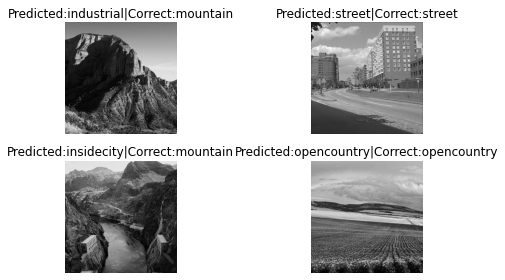

In [54]:
# # visualize train split
print("Examples from train split:")

visualize(simple_model_dropout, 'train', get_fundamental_transforms(inp_size, dataset_mean, dataset_std))

Examples from test split:


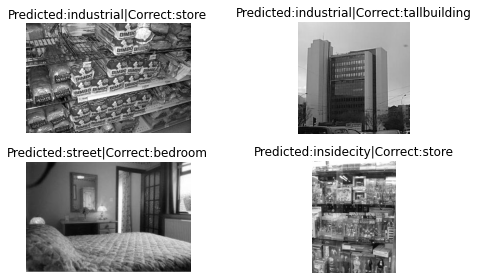

In [55]:
# # visualize test split
print("Examples from test split:")
visualize(simple_model_dropout, 'test', get_fundamental_transforms(inp_size, dataset_mean, dataset_std))

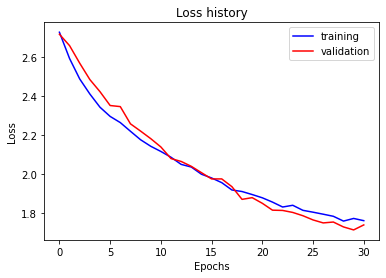

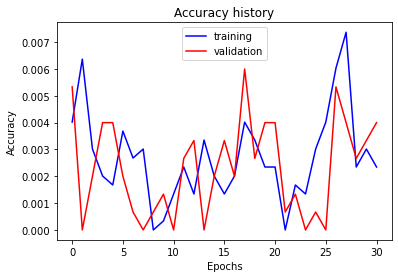

In [56]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [57]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print('Train Accuracy = {:.4f}; Validation Accuracy = {:.4f}'.format(train_accuracy, validation_accuracy))

Train Accuracy = 0.0023; Validation Accuracy = 0.0040


Similar to the previous part, now plot out the loss and accuracy history. Also copy the plots onto the report, and answer the questions accordingly.

**TODO 14:** Achieve **52%** validation accuracy for full credits for this part.

## EC2 Pretrained AlexNet
You can see that after the above adjustment, our model performance increases in terms of testing accuracy. Although the training accuracy drops, now it's closer to the testing values and that's more natural in terms of performance. But we are not satisfied with the final performance yet. Our model, in the end, is still a 2-layer SimpleNet and it might be capable of capturing some features, but could be improved a lot if we go **deeper**. In this part we are going to see the power of a famous model: AlexNet.

References:
- https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf

In [58]:
inp_size = (224, 224)


PyTorch has provided us with pre-trained models like AlexNet, so what you want to do is to load the model first, and then adjust some of the layers such that it fits with our own dataset, instead of outputing scores to 1000 classes from the original AlexNet model.

There are many reasons for using pre-trained weights instead of training AlexNet from scratch:
1. We have a really small dataset. Alexnet has millions of parameters and will definitely overfit. The pre-trained alexnet will have access to millions of training images.
2. We save a lot of computation.

**TODO 15:** Switch to `my_alexnet.py`, and copy the network architecture and weights of all but the last fc layers from the pretrained network.

After you have defined the correct architecture of the model, make some tweaks to the existing layers: **freeze** the **convolutional** layers and first 2 **linear** layers so we don't update the weights of them. More instructions are in the docstring.

Note that you are allowed to add more layers/unfreeze more layers if you see fit.

In [66]:
print("Testing your AlexNet architecture: ", verify(test_my_alexnet))

Testing your AlexNet architecture:  "Correct"


In [74]:
my_alexnet = MyAlexNet()
print(my_alexnet)

MyAlexNet(
  (conv_layers): Sequential()
  (fc_layers): Sequential(
    (0): AlexNet(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
        (1): ReLU(inplace=True)
        (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (4): ReLU(inplace=True)
        (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (7): ReLU(inplace=True)
        (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (9): ReLU(inplace=True)
        (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (avgpool): AdaptiveAvgPool2d(output_size

In [75]:
# TODO: add a decent initial setting and tune from there
optimizer_config = {
  "optimizer_type": "adam",
  "lr": 1e-3,
  "weight_decay": 1e-5
}

In [88]:
my_alexnet = MyAlexNet()
optimizer = get_optimizer(my_alexnet, optimizer_config)

trainer = Trainer(data_dir=data_base_path, 
                  model = my_alexnet,
                  optimizer = optimizer,
                  model_dir = os.path.join(model_base_path, 'alexnet'),
                  train_data_transforms = get_data_augmentation_transforms(inp_size, dataset_mean, dataset_std),
                  test_data_transforms = get_fundamental_transforms(inp_size, dataset_mean, dataset_std),
                  batch_size = 32,
                  load_from_disk = False,
                  cuda = is_cuda
                 )

The following training cell will take roughly 20 minutes or slightly more using CPU (but possibly under 5 minute using GPU depending on the batch size; the TAs got it within 3 minutes on a GTX1060).

In [84]:
trainer.train(num_epochs=5)

Epoch:0, Training Loss:2.9355, Validation Loss:2.8399
Epoch:1, Training Loss:1.0328, Validation Loss:0.9290
Epoch:2, Training Loss:0.8218, Validation Loss:0.7368
Epoch:3, Training Loss:0.7585, Validation Loss:0.7126
Epoch:4, Training Loss:0.7120, Validation Loss:0.6360
Epoch:5, Training Loss:0.6492, Validation Loss:0.5721


Now let's have your model predict on some examples and see how well it performs qualitatively.

Examples from train split:


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 1000])

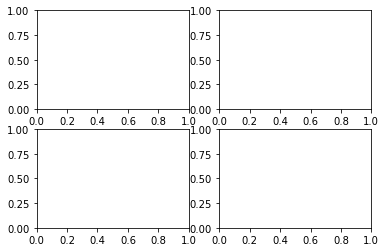

In [89]:
# # visualize train split
print("Examples from train split:")
visualize(my_alexnet, 'train', get_fundamental_transforms(inp_size, dataset_mean, dataset_std))

Examples from test split:


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 1000])

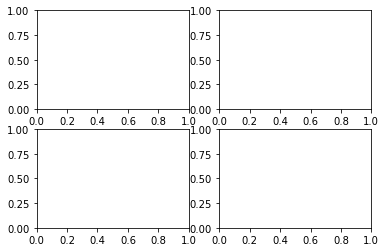

In [86]:
# # visualize test split
print("Examples from test split:")
visualize(my_alexnet, 'test', get_fundamental_transforms(inp_size, dataset_mean, dataset_std))

In [ ]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [ ]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print('Train Accuracy = {:.4f}; Validation Accuracy = {:.4f}'.format(train_accuracy, validation_accuracy))

**TODO 16**: Like both previous sections, you are required to pass a threshold of **85%** for this part. Copy the plots and values onto the report and answer questions accordingly.

You have completed all the code required for this PS. We hope you enjoyed this course and learnt something useful from this course.

Please revisit PS5.pdf and complete the report.